<center><h1>Project 03: How does geometry affect the size of a critical nuclear reactor?</h1>
<h2>PHYS 210 </h2>
<h3>Andrea Schildhorn </h3></center>

# Introduction

In this notebook, we will explore how reactor geometry and size influence the effectiveness of Uranium-235 fission. We will:

1. Simulate fission within both cubical and spherical reactor geometries.
2. Examine how each reactor’s size affects the neutron multiplication factor, $k$, over several generations.
3. Apply Bayesian Optimization to find the reactor dimensions that achieve $k = 1$, ensuring a critical (self-sustaining) chain reaction.
By comparing the optimized results for both shapes, we will identify which geometry is more likely to reach criticality under similar conditions, and understand the underlying reasons why.

---

## Background

### Key Terms
- **Thermal Neutron:**  
  A free neutron with kinetic energy similar to the average energy of its environment.

- **Fission in Uranium-235:**  
  When a Uranium-235 nucleus absorbs a thermal neutron, it undergoes fission, releasing at least two more neutrons along with energy. The released neutrons may interact with other Uranium-235 nuclei, causing a chain reaction.

- **Multiplication Factor ($k$):**  
  Represents the average number of neutrons per fission that go on to trigger additional fission processes.  
  - $k > 1$: Supercritical reaction - This means an exponential growth of neutrons.
  - $k < 1$: Subcritical reaction - This means that the reactions won't be able to sustain themselves and will die out over time.
  - $k = 1$: Criticality - This means that the number of neutrons is stable and predictable over time.


- **Mean Free Path ($\lambda$):**  
  The average distance a neutron travels before being absorbed or escaping the sample. In our simulation, the mean free path is defined as $\lambda = 0.15 \, \text{m}$

- **Lost Neutrons:**  
  Neutrons that escape the boundary of the reactor (cube or sphere) cannot contribute to further fission and are considered lost.

### Simulation Process
In our physical simulation, we will be recreating the process of Uranium-235 nuclear fission inside the core of a nuclear reactor. Fission occurs when an unstable Uranium-235 nucleus absorbs a thermal neutron and splits into two smaller fission fragments, releasing additional free neutrons in the process. These newly released neutrons can, in turn, induce further fissions in other Uranium-235 nuclei, continuing the chain reaction over several generations.

The increase or decrease in the rate of these reactions is quantified by the reactor’s criticality, represented by $k$. The value of $k$ tells us whether the chain reaction produces an increasing amount of fissions ($k > 1$), a decreasing amount ($k < 1$), or is perfectly self-sustaining ($k = 1$).

After each generation, each neutron will travel a random distance approximately equal to the mean free path before either causing another fission or escaping the reactor boundaries. If a neutron’s path takes it outside the reactor region, it is lost and cannot contribute to further fissions. Those neutrons that remain within the reactor volume have a chance to induce fission in another Uranium-235 nucleus, thereby sustaining the chain reaction.
### Simulation Assumptions
To model the behavior of neutrons in different reactor geometries, the following simulation parameters are used:
- **Initial Neutron Count ($N_0$):** The initial number of thermal neutrons in the reactor. For this simulation:  
  $N_0 = 250$ 
- **Neutrons Per Fission:** Each fission reaction produces, on average:  
  $\text{neutrons per fission} = 2$ 
- **Generations:** The simulation tracks:  
  $\text{maximum generations} = 3$
- **Trials:** Each simulation is run multiple times to average out randomness:  
  $\text{trials} = 250$

**Justification for $N_0$, $\text{neutrons per fission}$ and $\text{trials}$:** We choose these values based on a previously validated codebase that we use for cross-verification<sup>[[8]](https://physics210.github.io/p210-2024/Project03-Instructions.html)</sup>. By keeping $N_0$, the number of neutrons per fission, and the number of trials the same, we ensure that our results can be directly compared to a known, reliable standard. Moreover, these values are computationally manageable and do not significantly impact the overarching goal of our project, which is to investigate how geometry influences the reactor’s criticality. Since adjusting these parameters is not central to our objectives, and given that they have already been confirmed as feasible and effective in a trusted reference simulation, we maintain them as chosen.

### Reactor Geometries

**Cubical Reactor:**

- Characterized by its side length $a$.
- Neutrons must remain within the cube (from 0 to a along each axis) to induce further fission.
- Investigated range: $0.1 \le a \le 1.0$ This range was chosen to capture the meaningful variation of $k$ with respect to $a$. The lower bound ($a = 0.1\text{m}$) ensures that the cube is larger than the mean free path ($~0.15 \text{m}$), allowing neutrons to cause subsequent fissions rather than simply escaping. The upper bound ($a = 1.0\text{m}$) ensures that the cube is not excessively large (over ten times the mean free path), which would likely result in a supercritical system. Thus, the chosen interval balances the possibility of achieving a stable $k$ value without making the reactor unrealistically large or small.

**Spherical Reactor:**

- Characterized by its radius $r$.
- Neutrons must remain within the sphere (distance from center $\le r$) to contribute to further fission.
- Investigated range: $0.1 \le r \le 1.0.$ As with the cube, the spherical reactor’s range was selected through experimentation. This range provides a clear graphical relationship between $r$ and $k$, ensuring both subcritical and potentially critical regions are adequately represented.

---

## Bayesian Optimization<sup>[[3]](https://distill.pub/2020/bayesian-optimization/)</sup>

Bayesian Optimization is a technique for efficiently finding the global extrema of a complex function without exhaustively testing all possibilities. It is particularly helpful when evaluating the function is expensive or time-consuming, as is often the case with intricate simulations or experimental setups. In our scenario, we do not have a precise understanding of how the reactor dimensions ($a$ for a cube or $r$ for a sphere) relate to the criticality ($k$) of the system. Bayesian Optimization allows us to efficiently determine this relationship, guiding us toward the critical dimension that achieves $k = 1$ without requiring a tedious search.

Instead of testing all possibilities, Bayesian Optimization builds an initial model of the problem and uses this model to decide the most promising solutions to try next. This approach balances two key ideas<sup>[[6]](https://distill.pub/2020/bayesian-optimization/)</sup>:

- **Exploration**: Testing areas of the problem where the solution is uncertain to learn more about it.
- **Exploitation**: Focusing on areas that are already known to perform well.

The process uses three main components:

1. **The Objective Function**:  
   This is the problem we want to solve or optimize. For example, in this project, the objective is to minimize $\lvert k - 1 \rvert$, where $k$ represents the multiplication factor of the reactor.

2. **The Acquisition Function**:  
This function determines which candidate solution should be tested next, taking into account both the need to learn more about poorly understood regions of the problem and the desire to focus on areas that have already shown promising results

3. **The Gaussian Process (GP)**:  
   The Gaussian Process is a tool that builds a mathematical model of the problem based on the results of previous tests. It predicts:
   - The **mean**: The most likely outcome for a given solution.
   - The **uncertainty**: How confident the model is about that prediction.

#### How does the Gaussian Process work?<sup>[[9]](https://distill.pub/2019/visual-exploration-gaussian-processes/)</sup>

1. **Start with a guess**:  
   Initially, our model assumes that the relationship between reactor size ($a$ for cubes or $r$ for spheres) and the resulting $k$-value is smooth and well-behaved. This means that small changes in size lead to relatively small, predictable changes in $k$. We do not assume any specific pattern upfront, just that the function is not wildly fluctuating.

2. **Update with data**:  
   After running simulations at selected reactor sizes and recording the resulting $k$-values, the model updates its predictions about the underlying function. For example, if we find that at $a = 0.3\text{m}$, $k \gg 1$, the model adjusts to understand that increasing $a$ beyond this point might not be beneficial. Each new data point from our simulations refines the model, making it more accurate in the regions we have tested while it remains more uncertain in untested areas.

3. **Decide the next test**:  
   With each update, the Gaussian Process helps our acquisition function determine which reactor size to try next. If results indicate that increasing $r$ might bring $k$ closer to 1, the model encourages testing slightly larger $r$ values. Conversely, if a certain range shows diminishing returns, the model may suggest exploring other regions. This targeted approach allows us to efficiently zero in on the reactor dimension that achieves a $k$-value as close to 1 as possible, without exhaustively testing every option.

---

In this project, Bayesian Optimization will help:

1. **Optimize the cube side length ($a$)** for the cubical reactor.  
2. **Optimize the sphere radius ($r$)** for the spherical reactor.

The goal is to adjust $a$ and $r$ so that $\lvert k - 1 \rvert$ is minimized, which means achieving a $k$-factor of 1 (criticality). This ensures the reactor operates in a stable and controlled state.


---

## Motivation
We wish to investigate which geometries of a reactor are more likely to produce a critical reactor. This is because a critical reactor represents a safe and self-sustaining reaction that is easily predicted. In the case of subcritical reactions, too many uranium-235 neutrons escape the reactor, leading to a decrease in reactions across each generation. Fewer reactions result in a reduced power supply, making a subcritical reactor undesirable. In contrast, a supercritical reaction causes a sharp increase in uranium-235 neutrons over time, as too few neutrons escape the reactor. While this results in a very powerful reactor, it also makes the reactor unpredictable. Because exposure to radioactive particles is a major health concern, maintaining control of the reactor is critical<sup>[[4]](https://www.europhysicsnews.org/articles/epn/pdf/1987/11/epn19871811p133.pdf)</sup><sup>[[5]](https://www.osti.gov/opennet/manhattan-project-history/Science/NuclearPhysics/critical-mass.html)</sup>. This is most effectively achieved through a critical reactor, in which the number of uranium-235 neutrons remains stable across each generation.

---

To start our investigation, we first import all relevant packages and assign any fixed parameters to a variable.

In [3]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from mpl_toolkits.mplot3d import Axes3D

# Fixed parameters
mean_free_path = 0.15  # Mean free path in meters
N0 = 250  # Initial number of thermal neutrons
neutrons_per_fission = 2
max_generations = 3
trials =250  # number of trials per simulation run

Now we are ready to simulate!

## Finding ideal $a$ for a cubic reactor

In the code below, we simulate the nuclear fission process of Uranium-235 over three generations. From there, we define a function for running the simulation and a function for running the simulation on the cube specifically. Finally, we define our objective function as $|k-1|$. Then we are able to pass this function and our simulation into the `gp_minimize` function over our stated range of $a$ values. The output of our code tells us the optimized $a$ value, as well as the $k$ value that that side length produces.

Best a found:  0.2563187989931323
Minimum |k-1|:  0.00021058548963615031


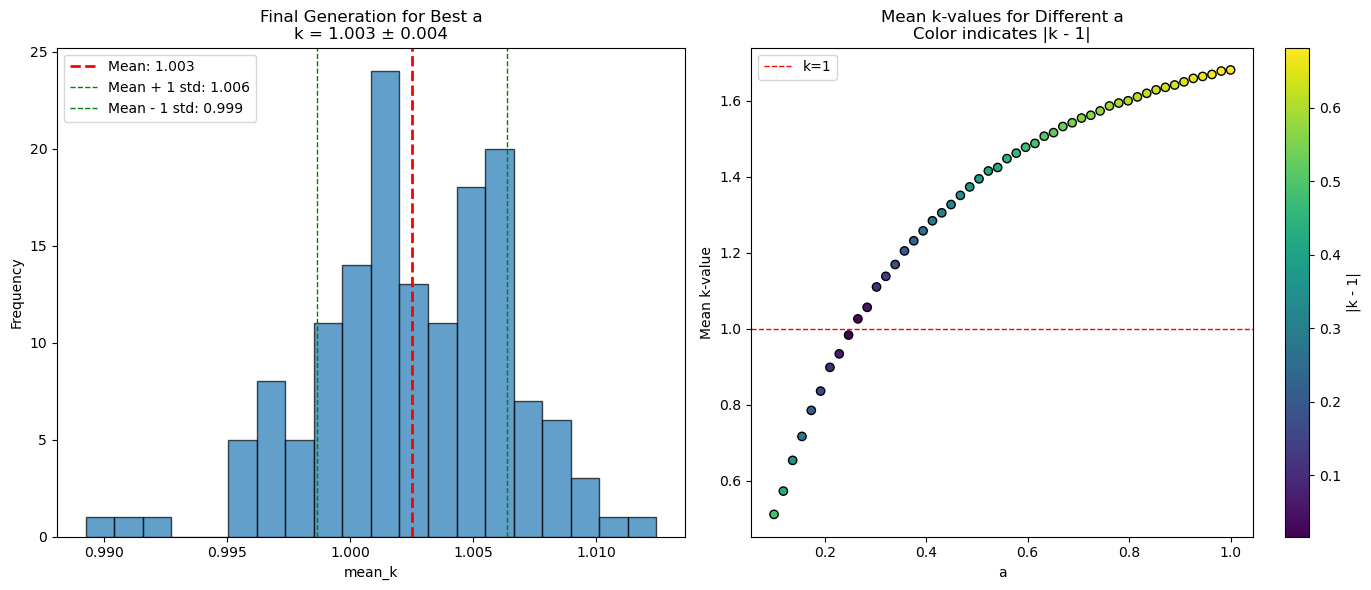

In [7]:
def simulate_generation(positions, mean_free_path, cube_size):\
    
    neutrons = positions.shape[0]

    # Generate random directions
    phi = np.random.uniform(0, 2*np.pi, size=neutrons)
    costheta = np.random.uniform(-1, 1, size=neutrons)
    theta = np.arccos(costheta)

    # Random distances traveled
    L = np.random.exponential(mean_free_path, size=neutrons)

    # Calculate displacements
    sin_theta = np.sin(theta)
    dx = L * sin_theta * np.cos(phi)
    dy = L * sin_theta * np.sin(phi)
    dz = L * costheta

    # New positions
    x_new = positions[:, 0] + dx
    y_new = positions[:, 1] + dy
    z_new = positions[:, 2] + dz

    # Determine which neutrons remain inside the cube
    absorbed_mask = (
        (x_new >= 0) & (x_new <= cube_size) &
        (y_new >= 0) & (y_new <= cube_size) &
        (z_new >= 0) & (z_new <= cube_size)
    )

    absorbed_positions = np.column_stack((x_new[absorbed_mask], y_new[absorbed_mask], z_new[absorbed_mask]))
    absorbed_neutrons = absorbed_positions.shape[0]

    # Generate new neutrons
    new_neutrons = absorbed_neutrons * neutrons_per_fission
    return new_neutrons, absorbed_positions


def run_simulation_cube(a):
    """
    Run a full simulation for a cube reactor of side length a.
    Returns the mean k-value of the last generation across multiple trials.
    """
    last_gen_k_values = []

    for _ in range(trials):
        # Initial neutron positions uniformly distributed inside the cube
        x0 = np.random.uniform(0, a, size=N0)
        y0 = np.random.uniform(0, a, size=N0)
        z0 = np.random.uniform(0, a, size=N0)
        positions = np.column_stack((x0, y0, z0))

        neutrons = N0
        total_neutrons = [neutrons]

        for _gen in range(max_generations):
            new_neutrons, absorbed_positions = simulate_generation(positions, mean_free_path, a)
            total_neutrons.append(new_neutrons)
            neutrons = new_neutrons

            # Update positions for the next generation
            if absorbed_positions.size > 0:
                positions = np.repeat(absorbed_positions, neutrons_per_fission, axis=0)
            else:
                positions = np.empty((0, 3))
                neutrons = 0

        # Compute final generation k-value
        # k = total_neutrons[max_generations] / total_neutrons[max_generations - 1] if denominator > 0
        final_gen = max_generations - 1
        prev_gen_neutrons = total_neutrons[final_gen]
        if prev_gen_neutrons > 0:
            k_value = total_neutrons[final_gen + 1] / prev_gen_neutrons
        else:
            k_value = 0

        last_gen_k_values.append(k_value)

    return np.mean(last_gen_k_values)


def objective(a):
    """
    Objective function for Bayesian optimization on cube side length.
    We want to minimize |k - 1|.
    """
    a_val = a[0]
    mean_k = run_simulation_cube(a_val)
    return abs(mean_k - 1)


# Define the search space for 'a'
space = [Real(0.1, 1, name='a')]

# Run Bayesian optimization
res = gp_minimize(
    objective,              # the objective function
    space,                  # the search space
    n_calls=50,             # number of evaluations
    n_initial_points=5,     # initial random evaluations
    random_state=42
)

optimal_a = res.x[0]
optimal_value = res.fun

print("Best a found: ", optimal_a)
print("Minimum |k-1|: ", optimal_value)

# Collect a distribution of mean_k values
num_runs = 150
mean_k_values = [run_simulation_cube(optimal_a) for _ in range(num_runs)]

# Calculate mean and std of the collected mean_k values
mean_val = np.mean(mean_k_values)
std_val = np.std(mean_k_values)

a_values = np.linspace(0.1, 1, 50)
k_values = [run_simulation_cube(val) for val in a_values]
k_diff = np.abs(np.array(k_values) - 1)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of mean_k_values
ax1.hist(mean_k_values, bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.3f}")
ax1.axvline(mean_val + std_val, color='green', linestyle='dashed', linewidth=1,
            label=f"Mean + 1 std: {mean_val+std_val:.3f}")
ax1.axvline(mean_val - std_val, color='green', linestyle='dashed', linewidth=1,
            label=f"Mean - 1 std: {mean_val-std_val:.3f}")
ax1.set_title(f"Final Generation for Best a\nk = {mean_val:.3f} ± {std_val:.3f}")
ax1.set_xlabel("mean_k")
ax1.set_ylabel("Frequency")
ax1.legend()

# Scatter plot of k_values vs a_values
sc = ax2.scatter(a_values, k_values, c=k_diff, cmap='viridis', edgecolor='black')
fig.colorbar(sc, ax=ax2, label='|k - 1|')
ax2.axhline(1, color='red', linestyle='dashed', linewidth=1, label='k=1')
ax2.set_xlabel("a")
ax2.set_ylabel("Mean k-value")
ax2.set_title("Mean k-values for Different a\nColor indicates |k - 1|")
ax2.legend()

plt.tight_layout()
plt.show()

Here, we find that the optimal cube side length is around $a = 0.25 \text{m}$. Running this value through our simulation again confirms that it yields a $k$-value very close to 1, indicating that the reactor is nearly critical.

An additional insight comes from our second plot, which reveals a logarithmic relationship between the mean $k$-value and the cube’s side length $a$. Intuitively, as the cube grows larger, the probability of neutrons escaping before inducing further fissions decreases. However, beyond a certain point, increasing the cube size has diminishing returns: the majority of fission events occur nearer to the core<sup>[[10]](https://www.engr.psu.edu/conedmat/courses/nuce497a/lamarsh_baratta-introduction_to_nuclear_engineering_textbook_3rd_edition.pdf)</sup>, so expanding the outer boundaries of the cube provides progressively smaller improvements in the neutron capture rate.

## Finding ideal $r$ for a spherical reactor
Now, we perform the above simulation but for a spherical reactor. Unlike the cube, where we check whether neutrons remain within the boundaries defined by the side length $a$, the spherical simulation accounts for the geometry by determining if neutrons have traveled beyond the radius $r$ of the sphere. This is done by calculating the distance of each neutron from the center of the sphere and comparing it to $r$. Neutrons that exceed this distance become *lost neutrons*.

C:\Users\17788\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [0.7167503390827541]
  warnings.warn(
C:\Users\17788\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [0.49184583563422446]
  warnings.warn(


Best r found:  0.15031720204240503
Minimum |k-1|:  2.693655756802471e-05


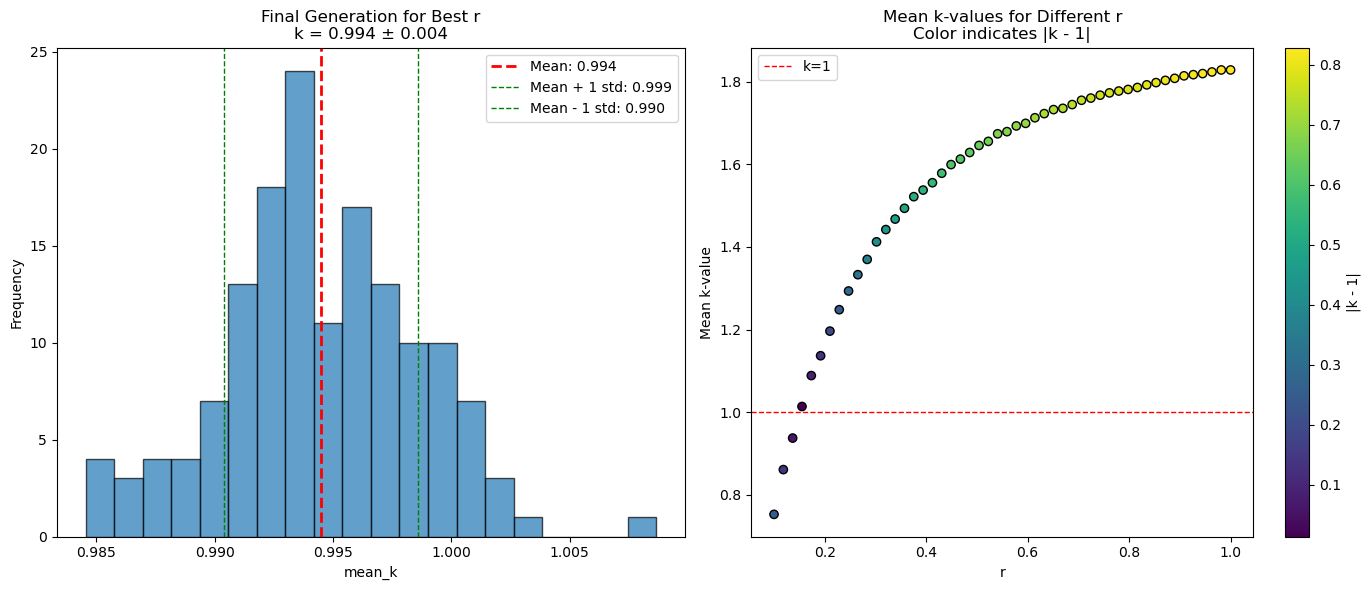

In [10]:
def simulate_generation_sphere(positions, mean_free_path, radius):
 
    neutrons = positions.shape[0]

    # Random directions
    phi = np.random.uniform(0, 2*np.pi, size=neutrons)
    costheta = np.random.uniform(-1, 1, size=neutrons)
    theta = np.arccos(costheta)

    # Random distances
    L = np.random.exponential(mean_free_path, size=neutrons)

    sin_theta = np.sin(theta)
    dx = L * sin_theta * np.cos(phi)
    dy = L * sin_theta * np.sin(phi)
    dz = L * costheta

    x_new = positions[:, 0] + dx
    y_new = positions[:, 1] + dy
    z_new = positions[:, 2] + dz

    inside_sphere = (x_new**2 + y_new**2 + z_new**2 <= radius**2)
    absorbed_positions = np.column_stack((x_new[inside_sphere], y_new[inside_sphere], z_new[inside_sphere]))
    absorbed_neutrons = absorbed_positions.shape[0]

    new_neutrons = absorbed_neutrons * neutrons_per_fission
    return new_neutrons, absorbed_positions


def run_simulation_sphere(r):
    """
    Run a full simulation for a spherical reactor of radius r.
    Returns the mean k-value of the last generation across multiple trials.
    """
    last_gen_k_values = []

    for _ in range(trials):
        # Distribute initial neutrons uniformly in the volume of the sphere
        u = np.random.rand(N0)
        radii = r * (u ** (1/3.0))

        phi_init = np.random.uniform(0, 2*np.pi, size=N0)
        costheta_init = np.random.uniform(-1, 1, size=N0)
        theta_init = np.arccos(costheta_init)

        x0 = radii * np.sin(theta_init) * np.cos(phi_init)
        y0 = radii * np.sin(theta_init) * np.sin(phi_init)
        z0 = radii * costheta_init
        positions = np.column_stack((x0, y0, z0))

        neutrons = N0
        total_neutrons = [neutrons]

        for _gen in range(max_generations):
            new_neutrons, absorbed_positions = simulate_generation_sphere(positions, mean_free_path, r)
            total_neutrons.append(new_neutrons)
            neutrons = new_neutrons

            if absorbed_positions.size > 0:
                positions = np.repeat(absorbed_positions, neutrons_per_fission, axis=0)
            else:
                positions = np.empty((0, 3))
                neutrons = 0

        # Compute final generation k-value
        final_gen = max_generations - 1
        prev_gen_neutrons = total_neutrons[final_gen]
        if prev_gen_neutrons > 0:
            k_value = total_neutrons[final_gen + 1] / prev_gen_neutrons
        else:
            k_value = 0

        last_gen_k_values.append(k_value)

    return np.mean(last_gen_k_values)


def objective(r):
    """
    Objective function for Bayesian optimization on sphere radius.
    We want to minimize |k - 1|.
    """
    r_val = r[0]
    mean_k = run_simulation_sphere(r_val)
    return abs(mean_k - 1)


# Define the search space for r
space = [Real(0.1, 1.0, name='r')]

# Run Bayesian optimization for the sphere
res = gp_minimize(
    objective,
    space,
    n_calls=50,
    n_initial_points=5,
    random_state=42
)

optimal_r = res.x[0]
optimal_value = res.fun

print("Best r found: ", optimal_r)
print("Minimum |k-1|: ", optimal_value)

# Evaluate and plot results for the sphere
best_r_k = run_simulation_sphere(optimal_r)

num_runs = 150
mean_k_values = [run_simulation_sphere(optimal_r) for _ in range(num_runs)]
mean_val = np.mean(mean_k_values)
std_val = np.std(mean_k_values)

r_values = np.linspace(0.1, 1.0, 50)
k_values = [run_simulation_sphere(val) for val in r_values]
k_diff = np.abs(np.array(k_values) - 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for sphere
ax1.hist(mean_k_values, bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.3f}")
ax1.axvline(mean_val + std_val, color='green', linestyle='dashed', linewidth=1,
            label=f"Mean + 1 std: {mean_val+std_val:.3f}")
ax1.axvline(mean_val - std_val, color='green', linestyle='dashed', linewidth=1,
            label=f"Mean - 1 std: {mean_val-std_val:.3f}")
ax1.set_title(f"Final Generation for Best r\nk = {mean_val:.3f} ± {std_val:.3f}")
ax1.set_xlabel("mean_k")
ax1.set_ylabel("Frequency")
ax1.legend()

# Scatter for sphere
sc = ax2.scatter(r_values, k_values, c=k_diff, cmap='viridis', edgecolor='black')
fig.colorbar(sc, ax=ax2, label='|k - 1|')
ax2.axhline(1, color='red', linestyle='dashed', linewidth=1, label='k=1')
ax2.set_xlabel("r")
ax2.set_ylabel("Mean k-value")
ax2.set_title("Mean k-values for Different r\nColor indicates |k - 1|")
ax2.legend()

plt.tight_layout()
plt.show()

Here we see that the ideal radius for a critical reactor is smaller and, importantly, close to the mean free path scale. Interestingly, we observe a similarly logarithmic dependency of the mean $k$-value on $r$, which carries analogous physical implications to what we found in the cubic reactor scenario.

In the cubic reactor, achieving criticality required dimensions larger than the mean free path, reflecting a balance between neutron production and losses at the boundaries. For the spherical reactor, however, the critical radius is actually smaller and is on the order of the mean free path. This is primarily due to the geometry: a sphere encloses the greatest volume for the smallest surface area. In practical terms, a sphere has the lowest ratio of boundary area to enclosed volume, which means fewer neutrons reach the boundary and escape<sup>[[2]](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf)</sup>. As a result, neutrons in a spherical reactor have a higher probability of undergoing fission-inducing collisions before escaping, enabling criticality at a smaller size than in a cube of comparable linear dimensions.

This size—comparable to the mean free path—signals that on average, a neutron is likely to cause a subsequent fission within just a few scatterings rather than travel a long distance before escaping. Consequently, the system reaches the critical balance between neutron production and loss at a smaller scale. The sphere’s geometry thus naturally leads to a minimized leakage rate, allowing for a smaller critical radius that still maintains a steady reproduction rate.

## Comparing both geometries
To better understand and visualize the results, we plot both reactor geometries (cube and sphere) and the distribution of neutrons that have either escaped or remained within each reactor across all three generations. This visual representation helps us clearly see the spatial spread of neutrons, providing insight into how reactor size and shape influence whether neutrons are absorbed and produce further fissions, or escape and fail to contribute to the chain reaction.

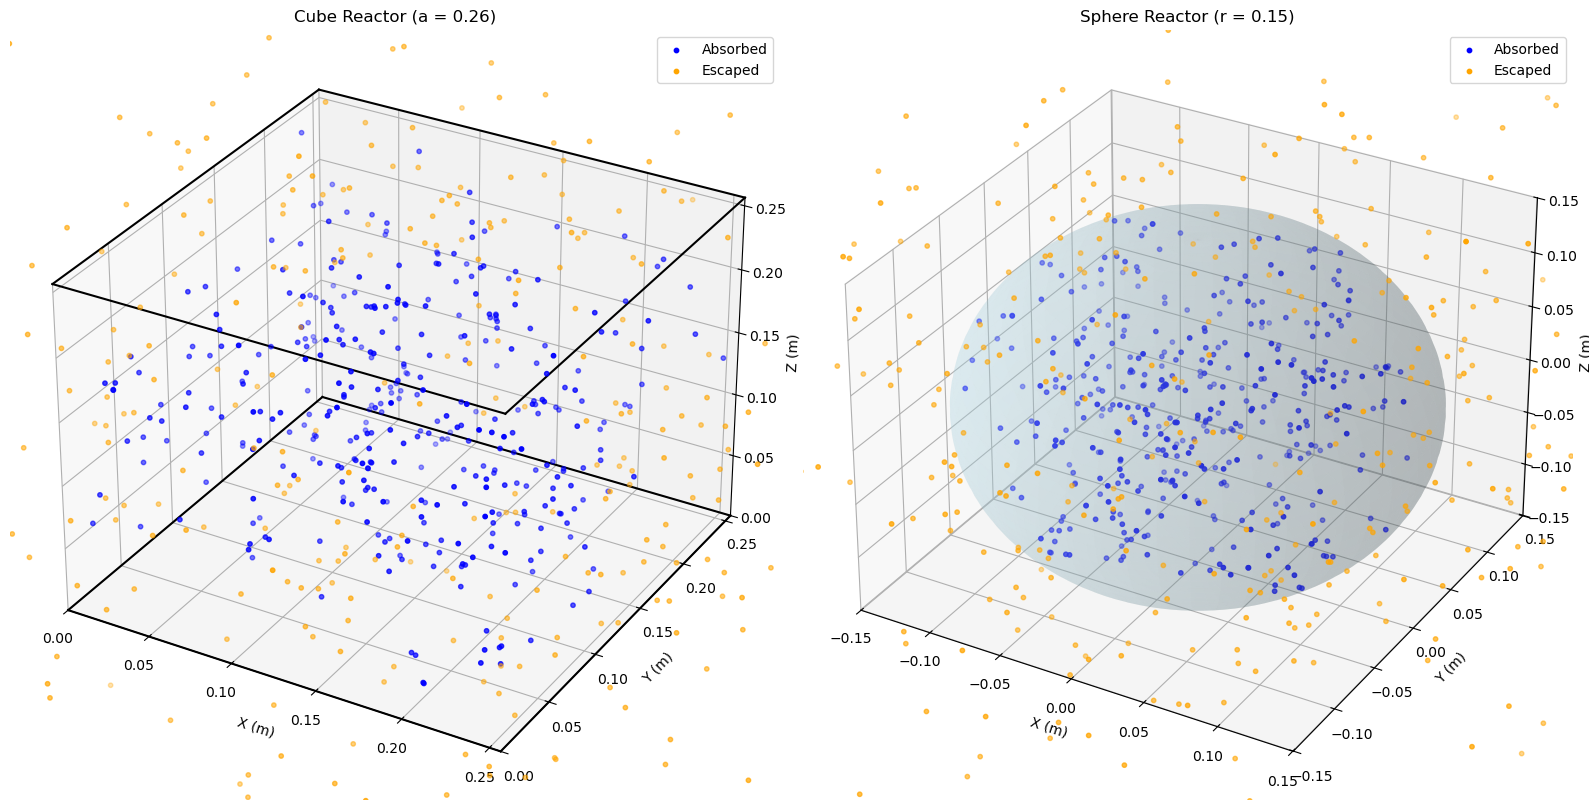

In [13]:
# Simulate neutron generation for a cube
def simulate_generation_cube(positions, mean_free_path, cube_size):
    neutrons = positions.shape[0]
    phi = np.random.uniform(0, 2 * np.pi, size=neutrons)
    costheta = np.random.uniform(-1, 1, size=neutrons)
    theta = np.arccos(costheta)
    L = np.random.exponential(mean_free_path, size=neutrons)
    dx = L * np.sin(theta) * np.cos(phi)
    dy = L * np.sin(theta) * np.sin(phi)
    dz = L * costheta
    x_new = positions[:, 0] + dx
    y_new = positions[:, 1] + dy
    z_new = positions[:, 2] + dz
    absorbed_mask = (
        (x_new >= 0) & (x_new <= cube_size) &
        (y_new >= 0) & (y_new <= cube_size) &
        (z_new >= 0) & (z_new <= cube_size)
    )
    escaped_positions = np.column_stack((x_new[~absorbed_mask], y_new[~absorbed_mask], z_new[~absorbed_mask]))
    absorbed_positions = np.column_stack((x_new[absorbed_mask], y_new[absorbed_mask], z_new[absorbed_mask]))
    return absorbed_positions, escaped_positions

# Simulate neutron generation for a sphere
def simulate_generation_sphere(positions, mean_free_path, radius):
    neutrons = positions.shape[0]
    phi = np.random.uniform(0, 2 * np.pi, size=neutrons)
    costheta = np.random.uniform(-1, 1, size=neutrons)
    theta = np.arccos(costheta)
    L = np.random.exponential(mean_free_path, size=neutrons)
    dx = L * np.sin(theta) * np.cos(phi)
    dy = L * np.sin(theta) * np.sin(phi)
    dz = L * costheta
    x_new = positions[:, 0] + dx
    y_new = positions[:, 1] + dy
    z_new = positions[:, 2] + dz
    inside_sphere = (x_new**2 + y_new**2 + z_new**2 <= radius**2)
    escaped_positions = np.column_stack((x_new[~inside_sphere], y_new[~inside_sphere], z_new[~inside_sphere]))
    absorbed_positions = np.column_stack((x_new[inside_sphere], y_new[inside_sphere], z_new[inside_sphere]))
    return absorbed_positions, escaped_positions

# Visualize neutrons for a cube reactor
def visualize_reactor_cube(a, mean_free_path, max_generations, N0):
    x0 = np.random.uniform(0, a, size=N0)
    y0 = np.random.uniform(0, a, size=N0)
    z0 = np.random.uniform(0, a, size=N0)
    positions = np.column_stack((x0, y0, z0))
    all_absorbed = []
    all_escaped = []

    for _ in range(max_generations):
        absorbed_positions, escaped_positions = simulate_generation_cube(positions, mean_free_path, a)
        all_absorbed.append(absorbed_positions)
        all_escaped.append(escaped_positions)
        if absorbed_positions.size > 0:
            positions = np.repeat(absorbed_positions, neutrons_per_fission, axis=0)
        else:
            positions = np.empty((0, 3))  # No neutrons left

    return np.vstack(all_absorbed), np.vstack(all_escaped)

# Visualize neutrons for a spherical reactor
def visualize_reactor_sphere(r, mean_free_path, max_generations, N0):
    u = np.random.rand(N0)
    radii = r * u**(1/3.0)
    phi = np.random.uniform(0, 2 * np.pi, size=N0)
    costheta = np.random.uniform(-1, 1, size=N0)
    theta = np.arccos(costheta)
    x0 = radii * np.sin(theta) * np.cos(phi)
    y0 = radii * np.sin(theta) * np.sin(phi)
    z0 = radii * costheta
    positions = np.column_stack((x0, y0, z0))
    all_absorbed = []
    all_escaped = []

    for _ in range(max_generations):
        absorbed_positions, escaped_positions = simulate_generation_sphere(positions, mean_free_path, r)
        all_absorbed.append(absorbed_positions)
        all_escaped.append(escaped_positions)
        if absorbed_positions.size > 0:
            positions = np.repeat(absorbed_positions, neutrons_per_fission, axis=0)
        else:
            positions = np.empty((0, 3))  # No neutrons left

    return np.vstack(all_absorbed), np.vstack(all_escaped)

# Collect positions for visualization
absorbed_cube, escaped_cube = visualize_reactor_cube(optimal_a, mean_free_path, max_generations, N0)
absorbed_sphere, escaped_sphere = visualize_reactor_sphere(optimal_r, mean_free_path, max_generations, N0)

# Create side-by-side plots
fig = plt.figure(figsize=(16, 8))

# Cube reactor plot
ax1 = fig.add_subplot(121, projection='3d')
# Plot cube boundary
cube_boundary = [0, optimal_a]
for z in cube_boundary:
    ax1.plot([cube_boundary[0], cube_boundary[1]], [cube_boundary[0], cube_boundary[0]], [z, z], color='black')
    ax1.plot([cube_boundary[1], cube_boundary[1]], [cube_boundary[0], cube_boundary[1]], [z, z], color='black')
    ax1.plot([cube_boundary[1], cube_boundary[0]], [cube_boundary[1], cube_boundary[1]], [z, z], color='black')
    ax1.plot([cube_boundary[0], cube_boundary[0]], [cube_boundary[1], cube_boundary[0]], [z, z], color='black')
# Plot neutrons
ax1.scatter(absorbed_cube[:, 0], absorbed_cube[:, 1], absorbed_cube[:, 2], s=10, color='blue', label='Absorbed')
ax1.scatter(escaped_cube[:, 0], escaped_cube[:, 1], escaped_cube[:, 2], s=10, color='orange', label='Escaped')
ax1.set_xlim(0, optimal_a)
ax1.set_ylim(0, optimal_a)
ax1.set_zlim(0, optimal_a)
ax1.set_title(f'Cube Reactor (a = {optimal_a:.2f})')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.legend()

# Sphere reactor plot
ax2 = fig.add_subplot(122, projection='3d')
# Plot sphere boundary
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = optimal_r * np.outer(np.cos(u), np.sin(v))
y = optimal_r * np.outer(np.sin(u), np.sin(v))
z = optimal_r * np.outer(np.ones(np.size(u)), np.cos(v))
ax2.plot_surface(x, y, z, color='lightblue', alpha=0.2)
# Plot neutrons
ax2.scatter(absorbed_sphere[:, 0], absorbed_sphere[:, 1], absorbed_sphere[:, 2], s=10, color='blue', label='Absorbed')
ax2.scatter(escaped_sphere[:, 0], escaped_sphere[:, 1], escaped_sphere[:, 2], s=10, color='orange', label='Escaped')
ax2.set_xlim(-optimal_r, optimal_r)
ax2.set_ylim(-optimal_r, optimal_r)
ax2.set_zlim(-optimal_r, optimal_r)
ax2.set_title(f'Sphere Reactor (r = {optimal_r:.2f})')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.legend()

plt.tight_layout()
plt.show()

## Final interpretation of results

Our simulations show that both a cube and a sphere can be adjusted to achieve a critical state, characterized by a $k$-value of approximately 1. In the case of the cube, the ideal side length is found to be larger than the mean free path. This is because, in a cube, neutrons have more surface area through which to escape, and thus, to sustain the chain reaction, the reactor must be larger to retain enough neutrons for subsequent fissions<sup>[[2]](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf)</sup>. On the other hand, the ideal radius for the spherical reactor is much smaller, and in fact, is on the order of the mean free path itself. The spherical geometry inherently reduces neutron leakage due to its minimal surface-to-volume ratio. As a result, even a relatively small sphere is sufficient to achieve a self-sustaining fission chain, making the critical radius smaller than the corresponding critical dimension in a cube. Examining the neutron position plots further reveals that neutrons tend to dissipate radially outward from their point of origin. This behavior highlights how geometry influences the probability of neutron absorption versus escape. Both shapes, however, were constrained so that their linear dimensions did not exceed ten times the mean free path, ensuring that the reactors were not pushed into an unrealistically large, supercritical regime. Interestingly, the optimal spherical radius matching the mean free path indicates that the reactor achieves criticality when a typical neutron has just enough room to either induce another fission or be lost within roughly one mean free path. This balance ensures that the number of neutrons in subsequent generations remains stable, supporting a $k$-value near 1. Ultimately, both reactor shapes—if properly scaled—achieve criticality. Thus, while the cube requires a larger dimension to offset higher leakage rates, and the sphere can remain relatively small, both geometries offer viable routes to constructing a critical reactor, demonstrating how geometric design considerations and mean free path lengths jointly determine reactor behavior.

## References

1. ChatGPT. (2024). *ChatGPT: Advanced conversational AI by OpenAI*. Retrieved from [https://openai.com](https://openai.com)

2. Duderstadt, J. J., & Hamilton, L. J. (1976). *Nuclear Reactor Analysis* (Chapter 3, Part D). John Wiley & Sons. Retrieved from [https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf)

3. Snoek, J., Larochelle, H., & Adams, R. P. (2020). *Bayesian optimization*. Retrieved from [https://distill.pub/2020/bayesian-optimization/](https://distill.pub/2020/bayesian-optimization/)

4. Cochran, J. (1987). *Nuclear reactors: An overview*. *Europhysics News, 18*(11), 133-136. Retrieved from [https://www.europhysicsnews.org/articles/epn/pdf/1987/11/epn19871811p133.pdf](https://www.europhysicsnews.org/articles/epn/pdf/1987/11/epn19871811p133.pdf)

5. U.S. Department of Energy. (n.d.). *Critical mass*. Retrieved from [https://www.osti.gov/opennet/manhattan-project-history/Science/NuclearPhysics/critical-mass.html#:~:text=A%20mass%20of%20material%20that,of%20fissionable%20material%20creates%20an](https://www.osti.gov/opennet/manhattan-project-history/Science/NuclearPhysics/critical-mass.html#:~:text=A%20mass%20of%20material%20that,of%20fissionable%20material%20creates%20an)

6. Scikit-Optimize. (n.d.). *Bayesian optimization example*. Retrieved from [https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html)

7. Scikit-Optimize. (2020). *Scikit-Optimize GitHub repository*. Retrieved from [https://github.com/scikit-optimize/scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

8. Physics 210. (2024). *Project 03 Instructions*. Retrieved from [https://physics210.github.io/p210-2024/Project03-Instructions.html](https://physics210.github.io/p210-2024/Project03-Instructions.html)

9. Distill. (2019). *A Visual Exploration of Gaussian Processes*. Retrieved from [https://distill.pub/2019/visual-exploration-gaussian-processes/](https://distill.pub/2019/visual-exploration-gaussian-processes/)

10. Lamarsh, J. R., & Baratta, A. J. (2001). *Introduction to Nuclear Engineering* (3rd ed.). Prentice Hall. Retrieved from [https://www.engr.psu.edu/conedmat/courses/nuce497a/lamarsh_baratta-introduction_to_nuclear_engineering_textbook_3rd_edition.pdf](https://www.engr.psu.edu/conedmat/courses/nuce497a/lamarsh_baratta-introduction_to_nuclear_engineering_textbook_3rd_edition.pdf)


## Appendix 1: Code validation

### A1.1: Confirmation of base code

A good piece of evidence that our simulation is working as expected is by cross-checking our simulation results with the results provided from PHYS 210<sup>[[8]](https://physics210.github.io/p210-2024/Project03-Instructions.html)</sup> course. Below is the code for our simulation, which outputs a histogram of the mean k-values produced over 250 simulations. We can compare the magnitude of the mean k-value for each generation as well as the standard deviation for each generation. By making sure these two results are the same, we can be certain that the simulation portion of our code works as intended.

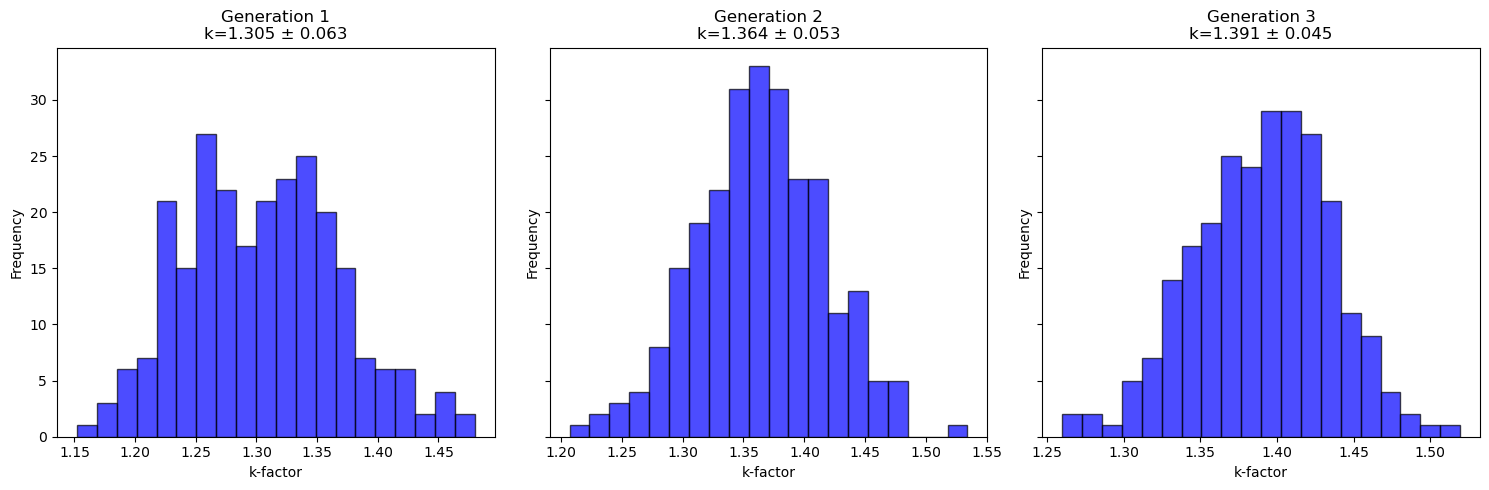

Above this text are the results produced in our fission simulation. Below this text are the results produced by the PHYS 210 simulation.


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Known parameters
a = 0.5  # Length of the cube's side in meters
mean_free_path = 0.15  # Mean free path in meters
N0 = 250  # Initial number of thermal neutrons
neutrons_per_fission = 2
max_generations = 3
trials = 250

def simulate_generation(positions, mean_free_path, cube_size):
    neutrons = positions.shape[0]

    # Generate random directions correctly
    phi = np.random.uniform(0, 2*np.pi, size=neutrons)
    costheta = np.random.uniform(-1, 1, size=neutrons)
    theta = np.arccos(costheta)

    # Generate random distances traveled before absorption
    L = np.random.exponential(mean_free_path, size=neutrons)

    # Calculate displacements in Cartesian coordinates
    dx = L * np.sin(theta) * np.cos(phi)
    dy = L * np.sin(theta) * np.sin(phi)
    dz = L * costheta

    # New positions
    x_new = positions[:, 0] + dx
    y_new = positions[:, 1] + dy
    z_new = positions[:, 2] + dz

    # Determine which neutrons remain inside the cube
    absorbed_mask = (
        (x_new >= 0) & (x_new <= cube_size) &
        (y_new >= 0) & (y_new <= cube_size) &
        (z_new >= 0) & (z_new <= cube_size)
    )
    absorbed_positions = np.column_stack((x_new[absorbed_mask], y_new[absorbed_mask], z_new[absorbed_mask]))
    absorbed_neutrons = len(absorbed_positions)

    # New neutrons generated
    new_neutrons = absorbed_neutrons * neutrons_per_fission
    return new_neutrons, absorbed_positions

# Main simulation loop
all_k_values = {gen: [] for gen in range(max_generations)}

for trial in range(trials):
    # Initial positions
    x0 = np.random.uniform(0, a, size=N0)
    y0 = np.random.uniform(0, a, size=N0)
    z0 = np.random.uniform(0, a, size=N0)
    positions = np.column_stack((x0, y0, z0))
    neutrons = N0
    total_neutrons = [neutrons]

    for gen in range(max_generations):
        new_neutrons, absorbed_positions = simulate_generation(positions, mean_free_path, a)
        total_neutrons.append(new_neutrons)
        neutrons = new_neutrons

        if absorbed_positions.size > 0:
            positions = np.repeat(absorbed_positions, neutrons_per_fission, axis=0)
        else:
            positions = np.empty((0, 3))
            neutrons = 0

        if total_neutrons[gen] > 0:
            k_value = total_neutrons[gen + 1] / total_neutrons[gen]
            all_k_values[gen].append(k_value)
        else:
            all_k_values[gen].append(0)

# Plot histograms of k-values for each generation
fig, axes = plt.subplots(1, max_generations, figsize=(15, 5), sharey=True)

for gen in range(max_generations):
    mean_k = np.mean(all_k_values[gen])
    std_k = np.std(all_k_values[gen])
    axes[gen].hist(all_k_values[gen], bins=20, color='blue', alpha=0.7, edgecolor='black')
    axes[gen].set_title(f"Generation {gen + 1}\nk={mean_k:.3f} ± {std_k:.3f}")
    axes[gen].set_xlabel("k-factor")
    axes[gen].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
print("Above this text are the results produced in our fission simulation. Below this text are the results produced by the PHYS 210 simulation.")

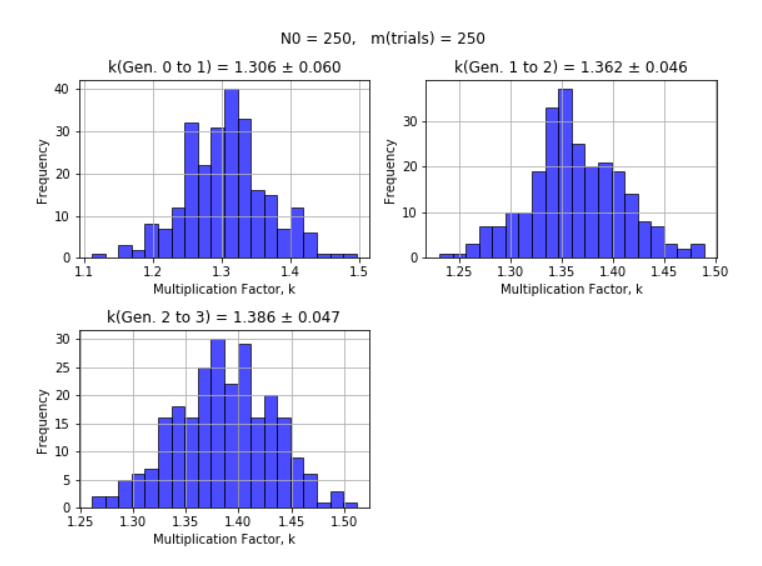

We see that the mean values are very close to each other for each generation, as well as the fact that we see a similar decrease in the standard deviation as we increase the generation number.

### A1.2: Try our verified simulation code for our ideal $a$ and $r$.

Now that our simulation works as intended, we can verify the effectiveness of the Bayesian Optimization by passing our ideal $r$ and $a$ back into the simulation code. By doing this, we can check if the resulting mean $k$ value is indeed close to 1. Achieving a mean $k$ value of 1 confirms that our optimization correctly identified the dimensions at which the reactor is critical, ensuring that the optimization process worked as intended.

Below are our mean k values for our ideal side length.


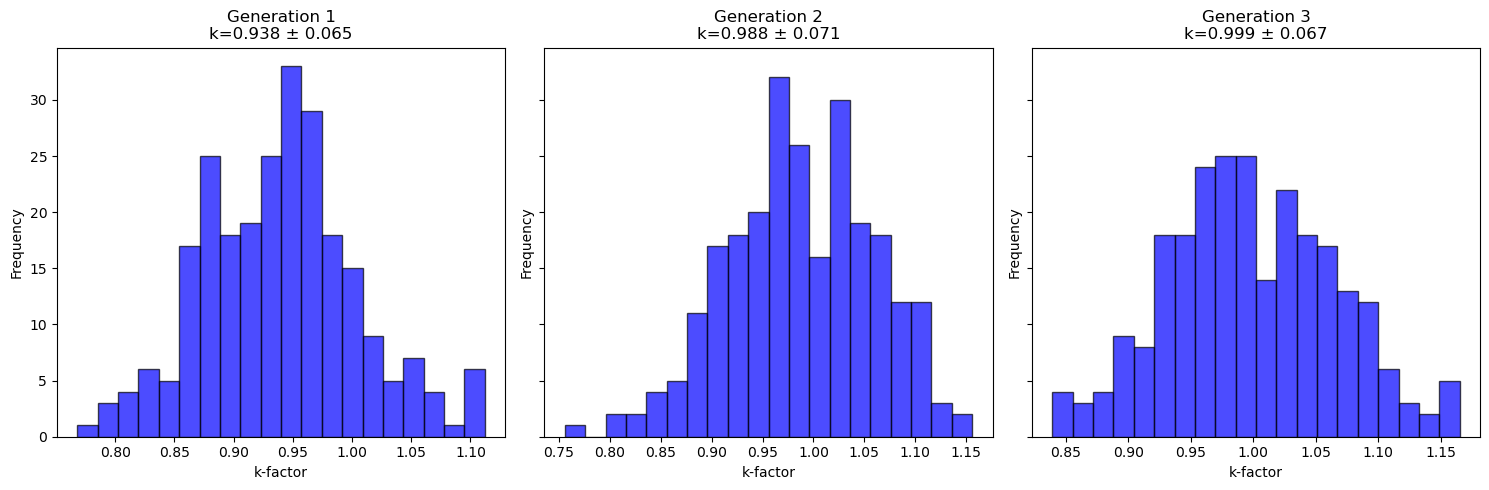

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Known parameters
a = optimal_a  # Length of the cube's side in meters
mean_free_path = 0.15  # Mean free path in meters
N0 = 250  # Initial number of thermal neutrons
neutrons_per_fission = 2
max_generations = 3
trials = 250

def simulate_generation(positions, mean_free_path, cube_size):
    neutrons = positions.shape[0]

    # Generate random directions correctly
    phi = np.random.uniform(0, 2*np.pi, size=neutrons)
    costheta = np.random.uniform(-1, 1, size=neutrons)
    theta = np.arccos(costheta)

    # Generate random distances traveled before absorption
    L = np.random.exponential(mean_free_path, size=neutrons)

    # Calculate displacements in Cartesian coordinates
    dx = L * np.sin(theta) * np.cos(phi)
    dy = L * np.sin(theta) * np.sin(phi)
    dz = L * costheta

    # New positions
    x_new = positions[:, 0] + dx
    y_new = positions[:, 1] + dy
    z_new = positions[:, 2] + dz

    # Determine which neutrons remain inside the cube
    absorbed_mask = (
        (x_new >= 0) & (x_new <= cube_size) &
        (y_new >= 0) & (y_new <= cube_size) &
        (z_new >= 0) & (z_new <= cube_size)
    )
    absorbed_positions = np.column_stack((x_new[absorbed_mask], y_new[absorbed_mask], z_new[absorbed_mask]))
    absorbed_neutrons = len(absorbed_positions)

    # New neutrons generated
    new_neutrons = absorbed_neutrons * neutrons_per_fission
    return new_neutrons, absorbed_positions

# Main simulation loop
all_k_values = {gen: [] for gen in range(max_generations)}

for trial in range(trials):
    # Initial positions
    x0 = np.random.uniform(0, a, size=N0)
    y0 = np.random.uniform(0, a, size=N0)
    z0 = np.random.uniform(0, a, size=N0)
    positions = np.column_stack((x0, y0, z0))
    neutrons = N0
    total_neutrons = [neutrons]

    for gen in range(max_generations):
        new_neutrons, absorbed_positions = simulate_generation(positions, mean_free_path, a)
        total_neutrons.append(new_neutrons)
        neutrons = new_neutrons

        if absorbed_positions.size > 0:
            positions = np.repeat(absorbed_positions, neutrons_per_fission, axis=0)
        else:
            positions = np.empty((0, 3))
            neutrons = 0

        if total_neutrons[gen] > 0:
            k_value = total_neutrons[gen + 1] / total_neutrons[gen]
            all_k_values[gen].append(k_value)
        else:
            all_k_values[gen].append(0)
print("Below are our mean k values for our ideal side length.")
# Plot histograms of k-values for each generation
fig, axes = plt.subplots(1, max_generations, figsize=(15, 5), sharey=True)

for gen in range(max_generations):
    mean_k = np.mean(all_k_values[gen])
    std_k = np.std(all_k_values[gen])
    axes[gen].hist(all_k_values[gen], bins=20, color='blue', alpha=0.7, edgecolor='black')
    axes[gen].set_title(f"Generation {gen + 1}\nk={mean_k:.3f} ± {std_k:.3f}")
    axes[gen].set_xlabel("k-factor")
    axes[gen].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Below are our mean k values for our ideal radius.


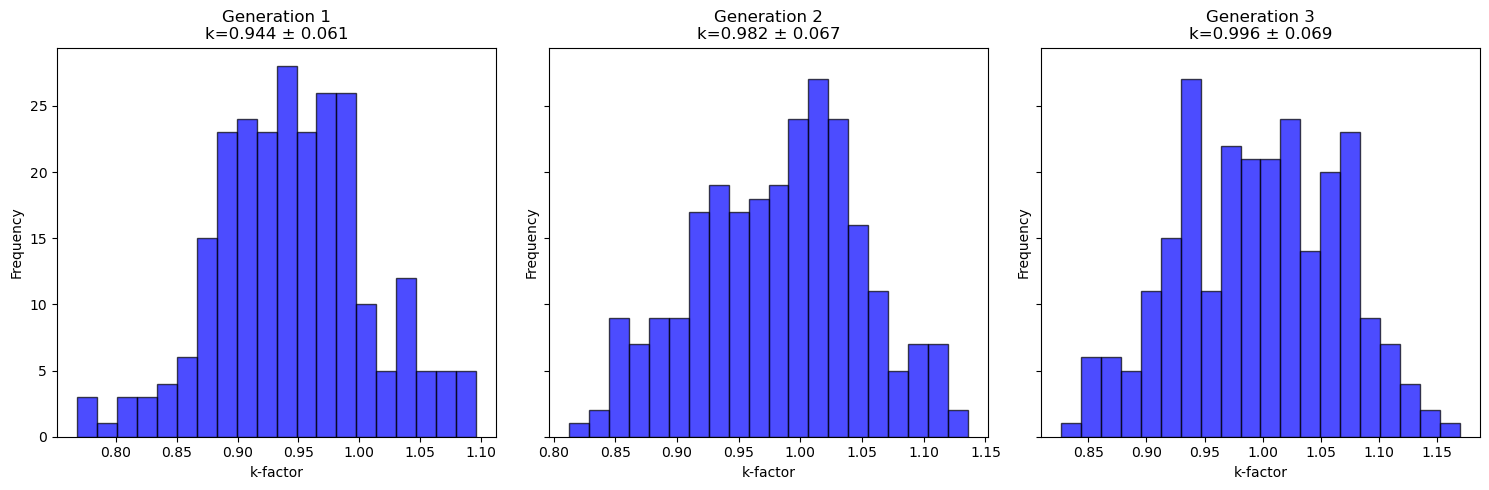

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Known parameters
r = optimal_r  # Radius of the sphere in meters
mean_free_path = 0.15  # Mean free path in meters
N0 = 250  # Initial number of thermal neutrons
neutrons_per_fission = 2
max_generations = 3
trials = 250

def simulate_generation_sphere(positions, mean_free_path, radius):
    neutrons = positions.shape[0]

    # Generate random directions
    phi = np.random.uniform(0, 2 * np.pi, size=neutrons)
    costheta = np.random.uniform(-1, 1, size=neutrons)
    theta = np.arccos(costheta)

    # Generate random distances traveled before absorption
    L = np.random.exponential(mean_free_path, size=neutrons)

    # Calculate displacements in Cartesian coordinates
    dx = L * np.sin(theta) * np.cos(phi)
    dy = L * np.sin(theta) * np.sin(phi)
    dz = L * costheta

    # New positions
    x_new = positions[:, 0] + dx
    y_new = positions[:, 1] + dy
    z_new = positions[:, 2] + dz

    # Determine which neutrons remain inside the sphere
    inside_sphere = (x_new**2 + y_new**2 + z_new**2 <= radius**2)
    absorbed_positions = np.column_stack((x_new[inside_sphere], y_new[inside_sphere], z_new[inside_sphere]))
    absorbed_neutrons = len(absorbed_positions)

    # New neutrons generated
    new_neutrons = absorbed_neutrons * neutrons_per_fission
    return new_neutrons, absorbed_positions

# Main simulation loop
all_k_values = {gen: [] for gen in range(max_generations)}

for trial in range(trials):
    # Initial positions inside the sphere
    u = np.random.uniform(0, 1, size=N0)  # Uniform sampling for volume
    radii = r * u**(1/3)  # Transform to radii
    phi = np.random.uniform(0, 2 * np.pi, size=N0)
    costheta = np.random.uniform(-1, 1, size=N0)
    theta = np.arccos(costheta)

    x0 = radii * np.sin(theta) * np.cos(phi)
    y0 = radii * np.sin(theta) * np.sin(phi)
    z0 = radii * costheta
    positions = np.column_stack((x0, y0, z0))
    neutrons = N0
    total_neutrons = [neutrons]

    for gen in range(max_generations):
        new_neutrons, absorbed_positions = simulate_generation_sphere(positions, mean_free_path, r)
        total_neutrons.append(new_neutrons)
        neutrons = new_neutrons

        if absorbed_positions.size > 0:
            positions = np.repeat(absorbed_positions, neutrons_per_fission, axis=0)
        else:
            positions = np.empty((0, 3))
            neutrons = 0

        if total_neutrons[gen] > 0:
            k_value = total_neutrons[gen + 1] / total_neutrons[gen]
            all_k_values[gen].append(k_value)
        else:
            all_k_values[gen].append(0)
print("Below are our mean k values for our ideal radius.")
# Plot histograms of k-values for each generation
fig, axes = plt.subplots(1, max_generations, figsize=(15, 5), sharey=True)

for gen in range(max_generations):
    mean_k = np.mean(all_k_values[gen])
    std_k = np.std(all_k_values[gen])
    axes[gen].hist(all_k_values[gen], bins=20, color='blue', alpha=0.7, edgecolor='black')
    axes[gen].set_title(f"Generation {gen + 1}\nk={mean_k:.3f} ± {std_k:.3f}")
    axes[gen].set_xlabel("k-factor")
    axes[gen].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


As we test our simulation over the optimized values of $a$ (cube side length) and $r$ (sphere radius), we observe that over three generations, the $k$-factor converges to 1, aligning with our expectations for achieving criticality. This convergence indicates that the system is stable and self-sustaining, as desired. However, the standard deviation of the results does not consistently decrease with each generation, unlike the behaviour observed when re-running our verified simulation under different conditions. This discrepancy could be attributed to factors such as randomness in the neutron interactions or slight imperfections in the Gaussian Process model used during optimization. Despite this variability, the consistent convergence of $k$ to 1 across generations provides strong evidence that our Bayesian Optimization successfully identified the optimal $a$ and $r$ values to achieve criticality. This outcome gives us confidence that our Bayesian Optimisation worked as intended.

## Appendix 2: Reflection questions

### Reflection 1: Coding Approaches (A)
*(How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.)*

I think I applied my coding knowledge very effectively in this project. I had the opportunity to work with several new functions and familiarize myself with how each step of the process worked, particularly with Bayesian Optimization (using the `skopt` library). I was able to install and set it up through my terminal using `pip`, which also allowed me to practice my Linux skills. This project was a great blend of coding, statistics, and Linux knowledge!

The most challenging aspect of the project was finding ways to verify my code, especially given my unfamiliarity with Bayesian Optimization. It required careful thought and testing to ensure that the results made sense and aligned with the theoretical expectations. 

### Reflection 2: Coding Approaches (B)
*(Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.)*

I feel that I did a good job with my visualizations, as they effectively complement the analysis and make the results easier to understand. I’m also proud of getting my basic simulation code to work, especially since it took quite a bit of effort to figure out. I had to consult with Joss to better understand how to simulate the particle positions, which was crucial in getting everything to function as intended (and finally starting my project).

That said, I think there’s room for improvement in making some parts of the code more concise. There are a few repetitive sections, particularly in how the simulation is defined, which could be cut down for better readability and maintainability. However, I don’t feel that these repetitions significantly detract from the overall quality of the project, as the core functionality is solid and the code isn't overly redundant.

### Reflection 3: Simulation phyiscs and investigation (A)
*(How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.)*

I think I did a good job of communicating the impact of different geometries in this project, and visualizing both reactors was especially helpful in illustrating these differences. I really enjoyed working on this project because it allowed me to dive deeply into the topic of nuclear reactors. When I started, I had very little understanding of how they worked, but by the end, I found myself genuinely curious about reactor safety and the trade-offs between critical and supercritical reactors. This was an unexpected area of interest for me as an astronomy student.

Additionally, I learned about the dispersion of neutrons in reactions and how they tend to have a higher probability density near the center of the reactor. This was a fascinating insight that deepened my appreciation for the physics underlying nuclear reactions. Overall, this project was a great opportunity to explore a new field while building on my skills in simulation and visualization.

### Reflection 4: Simulation phyiscs and investigation (B)
*(Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.)*

I think I did a good job ensuring that I am confident in my results. This is interesting because, in some ways, I felt like I left a lot of the heavy lifting to gp_minimize. Despite that, this project felt less tedious and buggy compared to others I’ve worked on, and I am confident in both my simulation and the conclusions I drew from my investigation.

That said, I feel like there’s more that could be said in the conclusion, particularly by leveraging my growing knowledge of how nuclear reactors work. If I had more time, I would focus on refining the conclusion to leave the project with a stronger "answer" or final takeaway. While I believe the conclusions I’ve reached are valid and well-supported, they don’t quite feel like a definitive “judge and gavel” verdict. Expanding the conclusion to tie everything together more decisively would add clarity and make the findings feel more impactful.

### Reflection 5: Effectiveness of your communication
*(Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.)*

I believe I did a good job formatting the notebook to ensure that each section is clear and easy to navigate. Additionally, I made a concerted effort to explain Bayesian Optimisation in a way that is accessible, providing enough context for readers who may not have a statistical background. However, upon reflection, I feel that I could have included a bit more technical nuance to enrich the explanation for readers with more advanced knowledge.

One area where I was uncertain was whether the objective of the project was consistently clear throughout the notebook. While I explained key components and concepts, I could revisit the introduction or conclusion to ensure the project's goals are explicitly tied to the results. Finally, I intended to include in-text citations for references, but I encountered issues with rendering footnote-style citations in Jupyter Notebook. As a result, I left them out, but addressing this issue in the future could improve the professionalism of the notebook.